In [2]:
pip install yfinance

     |████████████████████████████████| 5.5MB 6.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=03f621e6c5078216cfe025496a9630687995350fad136e306c81f3531f589fad
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
import pandas as pd
import numpy as np
import requests
import json
import ast
import yaml
import urllib
import yfinance
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
#from google.colab import drive

In [58]:
df_tweets = pd.read_csv('https://raw.githubusercontent.com/ml-group8/assignment/main/df_tweets_sentiment.csv')
# Keep only required columns
df_tweets = df_tweets[['created_at', 'id', 'tweet', 'sentiment', 'confidence']]

# Convert created_at column from string to datetime
def string_to_datetime(str_date):
  str_date = str_date[:19]
  return datetime.strptime(str_date, "%Y-%m-%dT%H:%M:%S")

df_tweets['created_at'] = df_tweets['created_at'].map(lambda strDateTime: string_to_datetime(strDateTime))

max_date_tweets = df_tweets['created_at'].max().replace(minute=0, second=0, microsecond=0)
min_date_tweets = df_tweets['created_at'].min().replace(minute=0, second=0, microsecond=0)

df_tweets
#print(min_date_tweets)
#print(max_date_tweets)

,created_at,id,tweet,sentiment,confidence
0,2021-03-20 15:59:46,1373303259964788740,I agree. I was looking to buy an electric car...,NEGATIVE,0.999987
1,2021-03-20 15:59:30,1373303194202353670,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,0.999818
2,2021-03-20 15:59:09,1373303103202725897,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,0.999840
3,2021-03-20 15:59:03,1373303077697126401,Germany electric car and 60% US states margin...,NEGATIVE,0.975843
4,2021-03-20 15:58:49,1373303019287248902,Germany electric car and 60% US states margin...,NEGATIVE,0.975843
...,...,...,...,...,...
15143,2021-03-13 17:01:27,1370782069505335299,"#Goodyearsbar #Timbo, Our #ClubCar limited sli...",POSITIVE,0.999870
15144,2021-03-13 17:01:15,1370782017634279426,Toyota X-Prologue Electric Car Teased Ahead of...,POSITIVE,0.970047
15145,2021-03-13 17:00:56,1370781938378756097,I’m driving fossil fuel out of my economy. I...,NEGATIVE,0.834038
15146,2021-03-13 17:00:37,1370781858179510274,Imagine buying an electric car to charge it at...,NEGATIVE,0.997597


In [63]:
from datetime import datetime, timedelta, timezone

#A/p the yfinance docs, Note: yahoo finance datetimes are received as UTC.
#however when visualizing the df the Datetime field is UTC-4 ???
drive_etf_ticker = yfinance.Ticker("DRIV")
drive_etf = drive_etf_ticker.history(
    start=min_date_tweets.strftime('%Y-%m-%d'),
    end=max_date_tweets.strftime('%Y-%m-%d'),
    interval='60m'
).reset_index()

# The Yahoo finance are in EST so convert them to UTC to match the tweets' timezone
drive_etf['DatetimeUTC'] = drive_etf['Datetime'].dt.tz_convert('UTC')
# Remove the timezone since we know it is at UTC and the tweets dataframe index is not tz aware
drive_etf['DatetimeUTC'] = drive_etf['Datetime'].dt.tz_convert(tz=None)

#set new UTC datetime as the index, we can visually compare to the original column to see the timezone correction
drive_etf.index = drive_etf['DatetimeUTC']
del drive_etf['DatetimeUTC']

drive_etf['pct_change'] = drive_etf['Close'].pct_change().fillna(0)
drive_etf = drive_etf[['pct_change', 'Close']]
#Let's only keep pct_change as our key dependent var and Close simply for debugging

drive_etf.head()

,pct_change,Close
DatetimeUTC,,
2021-03-15 13:30:00,0.000000,27.389999
2021-03-15 14:30:00,-0.004381,27.270000
2021-03-15 15:30:00,0.001100,27.299999
2021-03-15 16:30:00,0.001062,27.329000
2021-03-15 17:30:00,0.003326,27.419901


In [ ]:
# The stock market, unlike Twitter, is closed on weekend so we have gaps in our stock time series relative to our tweets
# We'll patch those gaps with interpolation
# TODO: Use after hours data if possible ???

#drive_etf.groupby('DatetimeUTC').resample('H')

In [59]:
# ETF 
# min: 2021-03-15 13:30
# max: 2021-03-19 19:30

# Tweets
# Min: 2021-03-13 17:00:02
# Max: 2021-03-20 15:59:46

## Resampling #####3

# Convert sentiment to numeric (Positive=1, negative=0)
df_tweets['numeric_sentiment'] = np.where(df_tweets['sentiment'] == 'POSITIVE', 1, 0)

# The ETF dataframe times are hourly but starting at 30min. We wil ladjust the tweets to match so we can join later
# It should still represent the general feeling at the hour+30min
df_tweets['created_at'] = df_tweets['created_at'].map(lambda created_at: created_at.round('H').replace(minute=30))
df_tweets


,created_at,id,tweet,sentiment,confidence,numeric_sentiment
0,2021-03-20 16:30:00,1373303259964788740,I agree. I was looking to buy an electric car...,NEGATIVE,0.999987,0
1,2021-03-20 16:30:00,1373303194202353670,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,0.999818,0
2,2021-03-20 16:30:00,1373303103202725897,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,0.999840,0
3,2021-03-20 16:30:00,1373303077697126401,Germany electric car and 60% US states margin...,NEGATIVE,0.975843,0
4,2021-03-20 16:30:00,1373303019287248902,Germany electric car and 60% US states margin...,NEGATIVE,0.975843,0
...,...,...,...,...,...,...
15143,2021-03-13 17:30:00,1370782069505335299,"#Goodyearsbar #Timbo, Our #ClubCar limited sli...",POSITIVE,0.999870,1
15144,2021-03-13 17:30:00,1370782017634279426,Toyota X-Prologue Electric Car Teased Ahead of...,POSITIVE,0.970047,1
15145,2021-03-13 17:30:00,1370781938378756097,I’m driving fossil fuel out of my economy. I...,NEGATIVE,0.834038,0
15146,2021-03-13 17:30:00,1370781858179510274,Imagine buying an electric car to charge it at...,NEGATIVE,0.997597,0


In [64]:
# count positive and negative tweets and convert them into a ratio of positive tweets to total tweets
df_tweet_sentiment_by_hr = df_tweets.assign(
 nb_positive = np.where(df_tweets['numeric_sentiment']==1,1,0),
 nb_negative = np.where(df_tweets['numeric_sentiment']==0,1,0)
  ).groupby('created_at').agg({'nb_positive':sum, 'nb_negative':sum})

df_tweet_sentiment_by_hr['positive_ratio'] = df_tweet_sentiment_by_hr['nb_positive']/(df_tweet_sentiment_by_hr['nb_positive'] + df_tweet_sentiment_by_hr['nb_negative'])

df_tweet_sentiment_by_hr.head()
#2021-03-15 13:30:00+00:00


#TODO: Maybe remove re=tweets (RT : prefix ???)
# TODO: Plug holes with after-hours info ???

,nb_positive,nb_negative,positive_ratio
created_at,,,
2021-03-13 17:30:00,25,8,0.757576
2021-03-13 18:30:00,53,32,0.623529
2021-03-13 19:30:00,27,25,0.519231
2021-03-13 20:30:00,104,26,0.800000
2021-03-13 21:30:00,87,27,0.763158


In [36]:
# For now let's just consider the tweets during trading hours
# ETF 
# min: 2021-03-15 13:30
# max: 2021-03-19 19:30

# Not needed if we left join from ETFs
#df_tweet_sentiment_by_hr = df_tweet_sentiment_by_hr.loc['2021-03-15 13:30':'2021-03-19 16:00']

#df_tweet_sentiment_by_hr.head()

,nb_positive,nb_negative,positive_ratio
created_at,,,
2021-03-15 14:00:00,66,33,0.666667
2021-03-15 15:00:00,65,33,0.663265
2021-03-15 16:00:00,68,31,0.686869
2021-03-15 17:00:00,67,33,0.670000
2021-03-15 18:00:00,59,41,0.590000


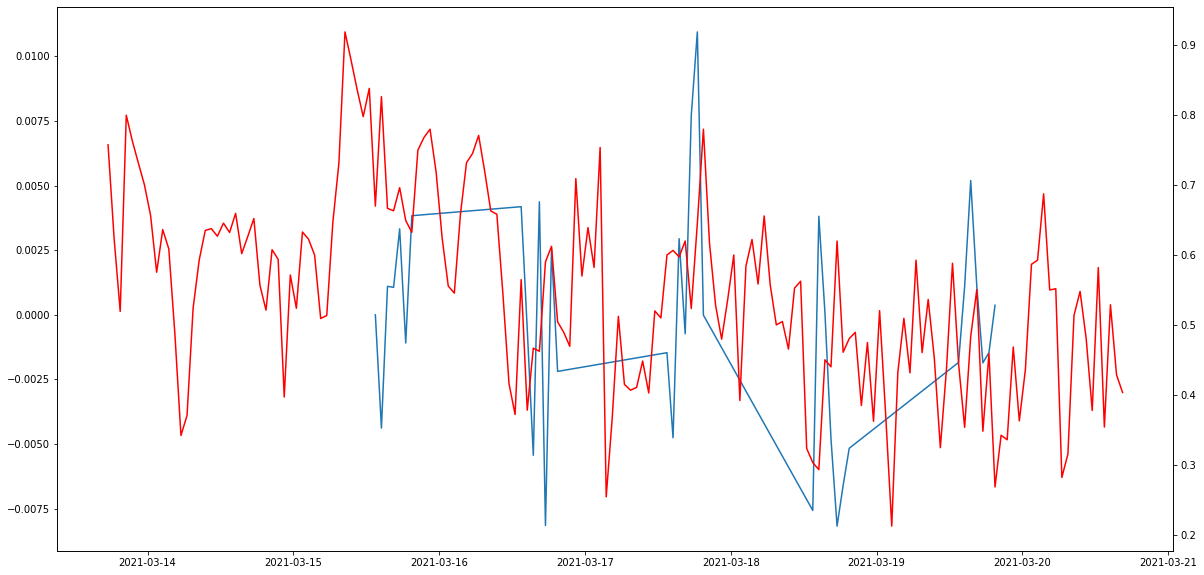

In [65]:
plt.rcParams['figure.figsize']=(20,10) # set the figure size
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # set up the 2nd axis
#ax1.plot(drive_etf['High']) 
ax1.plot(drive_etf['pct_change']) 
ax2.plot(df_tweet_sentiment_by_hr['positive_ratio'], color='red') 



#TODO: Log the returns

In [79]:
# Merge the tweets and stocks



# Might not need to strip out non-matching days a join is left join by default
df_merged = drive_etf.join(df_tweet_sentiment_by_hr)

#Keep only columns we need for the analysis
df_merged = df_merged[['pct_change','Close', 'positive_ratio']]
df_merged.head()
#2021-03-15 14:00:00

,pct_change,Close,positive_ratio
DatetimeUTC,,,
2021-03-15 13:30:00,0.000000,27.389999,0.670000
2021-03-15 14:30:00,-0.004381,27.270000,0.826531
2021-03-15 15:30:00,0.001100,27.299999,0.666667
2021-03-15 16:30:00,0.001062,27.329000,0.663265
2021-03-15 17:30:00,0.003326,27.419901,0.696296


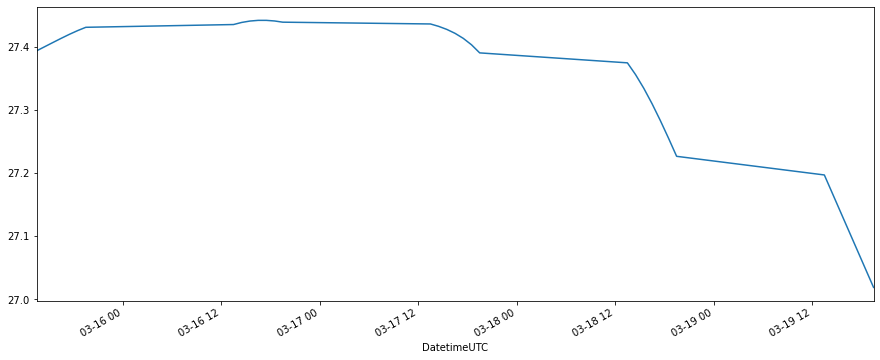

In [75]:
# Trend in stock price
from statsmodels.tsa.filters.hp_filter import hpfilter

cycle,trend = hpfilter(df_merged['Close'], lamb=1600)
trend.plot(figsize=(15,6)).autoscale(axis='x',tight=True)


Text(0.5, 0, 'Year')

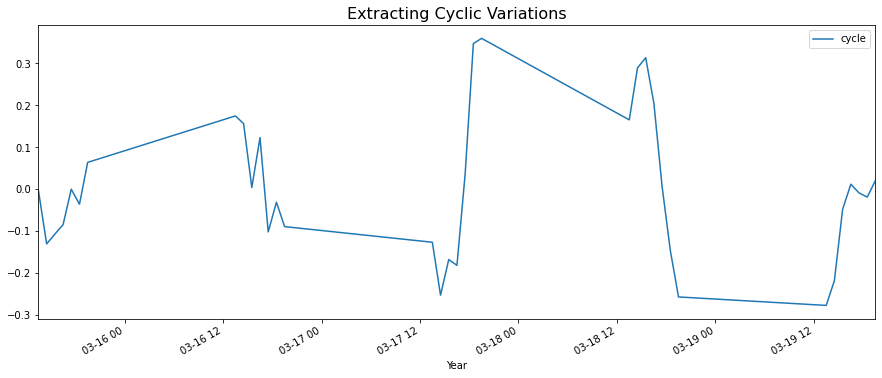

In [77]:
#DETECTING CYCLICAL VARIATIONS
#The following code shows how to decompose time-series data and visualize only a cyclic pattern:
from statsmodels.tsa.filters.hp_filter import hpfilter
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

cycle, trend = hpfilter(df_merged['Close'], lamb=1600)
df_merged['cycle'] =EXINUS_cycle
df_merged['trend'] =EXINUS_trend
df_merged[['cycle']].plot(figsize=(15,6)).autoscale(axis='x',tight=True)
plt.title('Extracting Cyclic Variations', fontsize=16)
plt.xlabel('Year')

[20:31:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


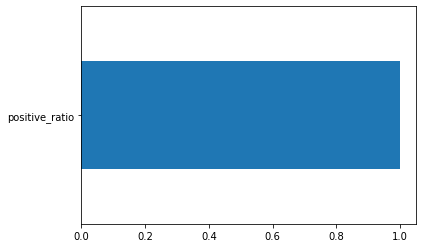

In [99]:
 import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
from numpy import loadtxt
from xgboost import XGBRegressor


tf.random.set_seed(123)
np.random.seed(123)

model = XGBRegressor()
model.fit(df_merged[['positive_ratio']],
    df[['pct_change']])
(pd.Series(model.feature_importances_, index=df[['positive_ratio']].columns)
   .nlargest(7)
   .plot(kind='barh'))

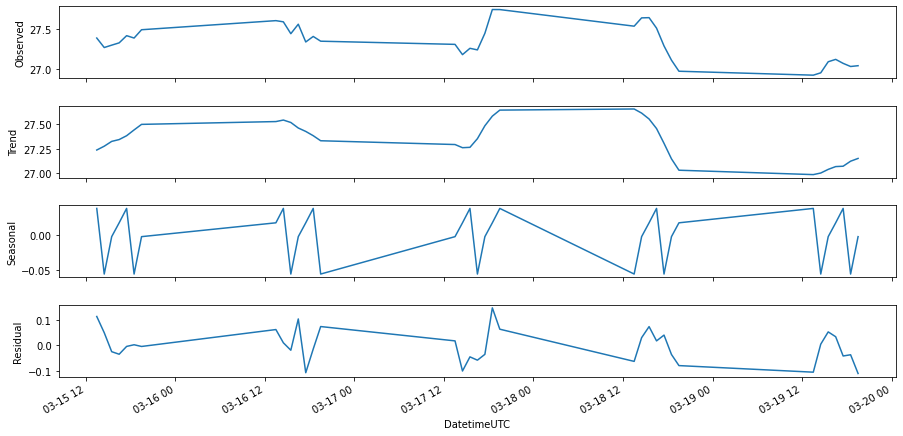

In [128]:
import statsmodels.api as sm



# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq', freq=4)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

df = df_merged.copy()
y = df[['Close']]
type(y)
seasonal_decompose(y)


In [167]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt


df = df_merged.copy()

df = df.reset_index()
df.dtypes

df['hr'] = pd.DatetimeIndex(df['DatetimeUTC']).hour
df['dayofweek'] = pd.DatetimeIndex(df['DatetimeUTC']).dayofweek
df['dayofmonth'] = pd.DatetimeIndex(df['DatetimeUTC']).day

df = df.drop(['DatetimeUTC'], axis = 1) 
X = df.copy()
del X['pct_change']

y = df['pct_change']

X_train, X_test, y_train, y_test = train_test_split(X, y)

model_rf = RandomForestRegressor(n_estimators=35, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print(r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print(r2_score(y_test, pred_test_rf))

0.002105370346216042
0.7757490796325109
0.0038859784951196744
0.11074534160642957


In [ ]:
# One-step Ahead prediction

from sklearn.preprocessing import MinMaxScaler

drive_etf = drive_etf.tz_localize(None)
df_tweet_sentiment_by_hr = df_tweet_sentiment_by_hr.tz_localize(None)
#drive_etf_closing =drive_etf['Close'].to_frame()

merged=pd.merge(drive_etf_closing, df_tweet_sentiment_by_hr,  how='inner', left_index=True, right_index=True)
drive_etf_closing.index.dtype


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#train_test_split()

# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
#scaler = MinMaxScaler()
#train_data = train_data.reshape(-1,1)
#test_data = test_data.reshape(-1,1)



dtype('<M8[ns]')